# Adaboost Model

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

from pathlib import Path

# May require pip installation
from tqdm.auto import tqdm

from importlib import reload

import sys
sys.path.append("../src")

import utils

In [2]:
plt.rcParams.update({'font.size': 22,
                            'figure.figsize': (12, 8)})

In [3]:
f_path = Path("../data/bank-full.csv")

df = pd.read_csv(f_path, delimiter=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
plt.style.use("seaborn")

In [5]:
RANDOM_STATE = 42

In [6]:
import utils
reload(utils)

X_train, X_test, y_train, y_test, scaler = utils.preprocess(df, random_state=RANDOM_STATE)
X_train

,day,campaign,pdays,previous,age_transf,balance_transf,duration_transf,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
41626,25,1,-1,0,1.041921,-0.408664,-0.594750,0,0,0,...,0,0,0,0,0,0,1,0,0,1
31347,16,13,-1,0,-1.218254,-0.296667,-0.680179,0,0,0,...,0,0,1,0,0,0,0,0,0,1
22563,22,1,-1,0,-0.464863,-0.396183,-0.528737,0,0,0,...,0,0,0,0,0,0,0,0,0,1
37243,13,1,-1,0,1.324443,-0.341334,-0.225854,0,1,0,...,0,0,0,1,0,0,0,0,0,1
32259,16,1,339,1,-0.276515,-0.150513,0.399328,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,18,1,-1,0,0.288529,-0.099605,7.124890,0,0,1,...,0,1,0,0,0,0,0,0,0,1
44732,8,1,92,1,-1.689124,-0.280574,-0.187023,0,0,0,...,0,0,0,0,0,0,1,0,0,0
38158,15,1,-1,0,-0.653211,-0.014869,-0.074413,0,0,0,...,0,0,0,1,0,0,0,0,0,1
860,7,1,-1,0,-0.747384,-0.393227,-0.571452,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [7]:
y_train.value_counts()

0    29972
1     3936
Name: y, dtype: int64

## Resampling with Synthetic Data

We can attempt to address the class imbalance in the problem through SMOTE:

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

y_train_res.value_counts()

0    29972
1    29972
Name: y, dtype: int64

## Adaboost

Let us first build a baseline model with default parameters:

In [11]:
%%time
adaboost_clf_base = AdaBoostClassifier(random_state=RANDOM_STATE)
adaboost_clf_base.fit(X_train_res, y_train_res)

CPU times: user 2.39 s, sys: 102 ms, total: 2.49 s
Wall time: 2.56 s


AdaBoostClassifier(random_state=42)

In [12]:
print("Train set:")
print(classification_report(y_train_res, adaboost_clf_base.predict(X_train_res)))

print("Test set:")
print(classification_report(y_test, adaboost_clf_base.predict(X_test)))

Train set:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     29972
           1       0.90      0.91      0.91     29972

    accuracy                           0.91     59944
   macro avg       0.91      0.91      0.91     59944
weighted avg       0.91      0.91      0.91     59944

Test set:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      9950
           1       0.46      0.66      0.54      1353

    accuracy                           0.87     11303
   macro avg       0.71      0.78      0.73     11303
weighted avg       0.89      0.87      0.88     11303



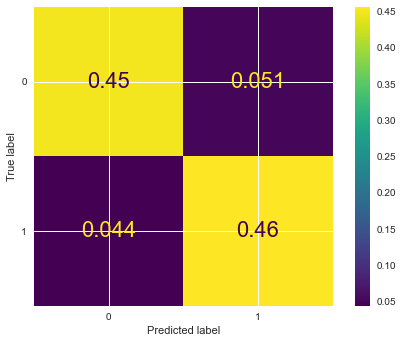

In [13]:
plot_confusion_matrix(adaboost_clf_base, X_train_res, y_train_res, normalize="all")

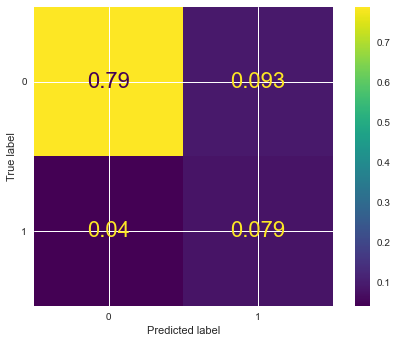

In [14]:
plot_confusion_matrix(adaboost_clf_base, X_test, y_test, normalize="all")

We can see that the test set performance is far worse than the train set performance. As such, it is likely that this
baseline estimator is overfit. The class imbalance is still problematic, as evidenced by the low f1-scores of the minority class predictions in the test set.

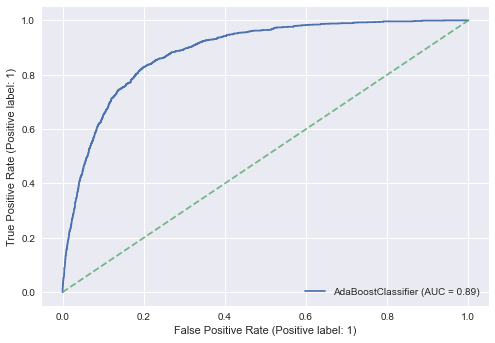

In [15]:
reload(utils)
utils.plot_roc_curve(adaboost_clf_base, X_test, y_test)

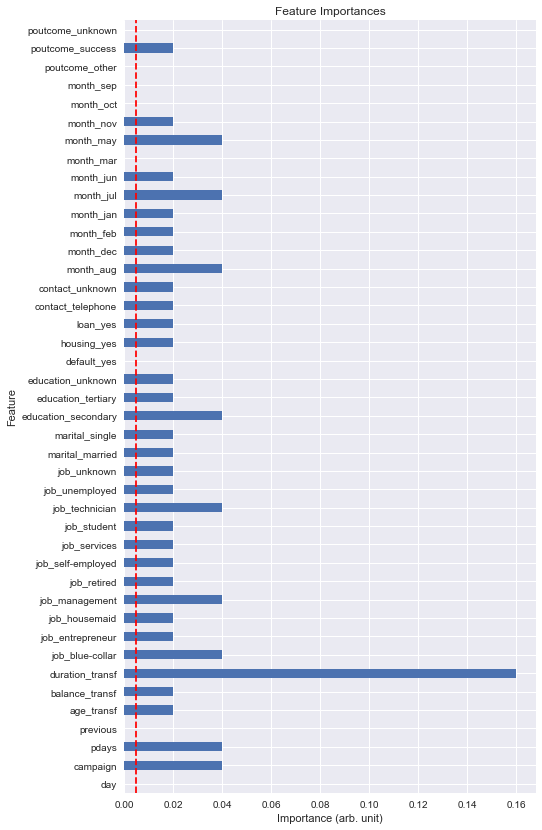

day                 0.0
previous            0.0
default_yes         0.0
month_mar           0.0
month_oct           0.0
month_sep           0.0
poutcome_other      0.0
poutcome_unknown    0.0
Name: Feature Importances, dtype: float64

In [16]:
reload(utils)

low_features = utils.plot_feature_importances(adaboost_clf_base.feature_importances_, X_train.columns,
                               thresh=0.005,
                              return_low_importance_features=True)

low_features

From this baseline model, it seems there are numerous features which provide little predictive power in our classifier. It may be worth dropping these features to reduce the runtime cost of training.

It is also interesting to note that the transformed `duration` feature has the most impact on the classifier.

## Dropping Low Importance Features

In [17]:
X_train_drop = X_train.drop(low_features.index, axis=1)
X_test_drop = X_test.drop(low_features.index, axis=1)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_res_drop, y_train_res_drop = smote.fit_resample(X_train_drop, y_train)


In [18]:
%%time
adaboost_clf_base_drop = AdaBoostClassifier(random_state=RANDOM_STATE)
adaboost_clf_base_drop.fit(X_train_res_drop, y_train_res_drop)

CPU times: user 2.2 s, sys: 91 ms, total: 2.29 s
Wall time: 2.36 s


AdaBoostClassifier(random_state=42)

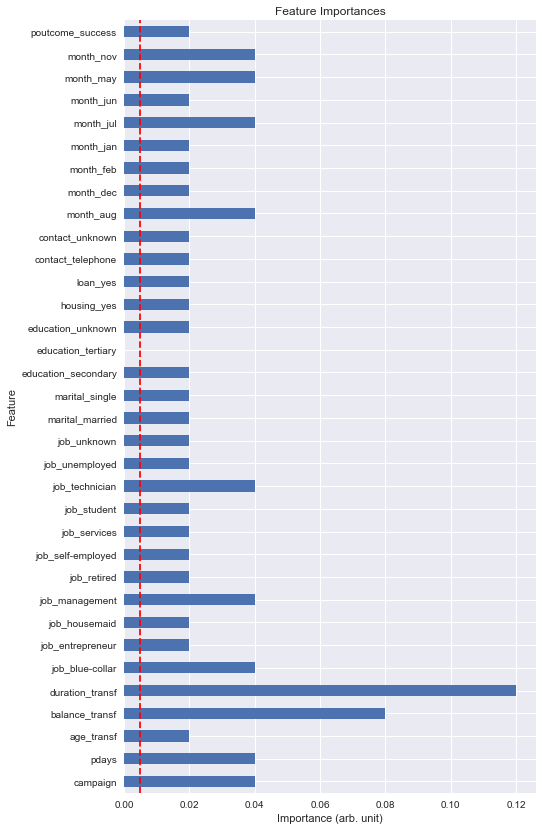

In [19]:
reload(utils)
utils.plot_feature_importances(adaboost_clf_base_drop.feature_importances_, X_train_res_drop.columns,
                              thresh=0.005)

In [20]:
print("Baseline Model:")
print("_________________________________________\n")
print("Train set:")
print(classification_report(y_train_res, adaboost_clf_base.predict(X_train_res)))

print("Test set:")
print(classification_report(y_test, adaboost_clf_base.predict(X_test)))

print("Baseline Model with Low Features Dropped:")
print("_________________________________________\n")
print("Train set:")
print(classification_report(y_train_res_drop, adaboost_clf_base_drop.predict(X_train_res_drop)))

print("Test set:")
print(classification_report(y_test, adaboost_clf_base_drop.predict(X_test_drop)))

Baseline Model:
_________________________________________

Train set:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     29972
           1       0.90      0.91      0.91     29972

    accuracy                           0.91     59944
   macro avg       0.91      0.91      0.91     59944
weighted avg       0.91      0.91      0.91     59944

Test set:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      9950
           1       0.46      0.66      0.54      1353

    accuracy                           0.87     11303
   macro avg       0.71      0.78      0.73     11303
weighted avg       0.89      0.87      0.88     11303

Baseline Model with Low Features Dropped:
_________________________________________

Train set:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     29972
           1       0.89      0.90      0.89     29972

    ac

Dropping the low importance features have resulted in negligible change in the performance metrics, for both the training and testing dataset.

However, the runtime cost saving is significant, especially when one considers the need for running cross-validation and grid searches later on in the analysis.

Thus, it is worth dropping the low importance features

## Cross-Validation of Baseline Model

In [201]:
cv_scores = pd.DataFrame(\
                      cross_validate(adaboost_clf, X_train_res_drop, y_train_res_drop, cv=5,
                            scoring=["accuracy", "f1_weighted", "f1_macro"])
                        )

In [202]:
cv_scores

,fit_time,score_time,test_accuracy,test_f1_weighted,test_f1_macro
0,2.067381,0.093686,0.811661,0.810187,0.810185
1,2.048353,0.100550,0.900409,0.900359,0.900359
2,2.154163,0.083046,0.900492,0.900423,0.900423
3,1.807849,0.077363,0.905747,0.905715,0.905715
4,1.826946,0.085809,0.905489,0.905441,0.905441


In [203]:
cv_scores.apply([np.mean, np.std])

,fit_time,score_time,test_accuracy,test_f1_weighted,test_f1_macro
mean,1.980938,0.088091,0.884759,0.884425,0.884425
std,0.154675,0.009114,0.040945,0.041582,0.041582


The baseline accuracy of $0.89 \pm 0.06$ seems quite reasonable however it is in fact no better than a worthless classifier trained on our imbalanced dataset.

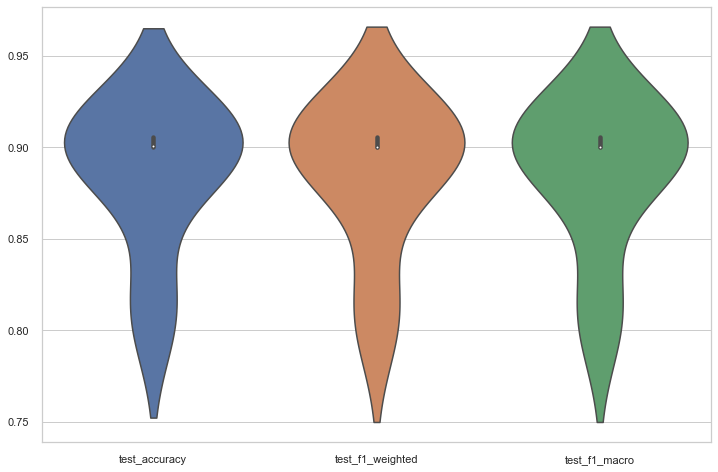

In [204]:
sns.set_theme(style="whitegrid")
sns.violinplot(data=cv_scores.drop(["fit_time", "score_time"], axis=1))
plt.show()

## Hyperparameter Tuning

In [205]:
adaboost_clf = AdaBoostClassifier(random_state=RANDOM_STATE)

adboost_paramgrid = {"n_estimators": range(20, 80, 10),
              "learning_rate": range(1, 5)}

# adboost_paramgrid = {"n_estimators": range(40, 60, 5),
#               "learning_rate": range(1, 2)}

# Use f1 macro score as scoring metric to penalise class imbalance (not needed if SMOTE used)
gs = GridSearchCV(adaboost_clf, adboost_paramgrid, scoring="f1_macro", verbose=True)
gs.fit(X_train_res_drop, y_train_res_drop)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': range(1, 5),
                         'n_estimators': range(20, 80, 10)},
             scoring='f1_macro', verbose=True)

In [206]:
gs.best_estimator_

AdaBoostClassifier(learning_rate=1, n_estimators=70, random_state=42)

In [207]:
print("Baseline Model:")
print("_________________________________________\n")
print("Train set:")
print(classification_report(y_train_res, adaboost_clf_base.predict(X_train_res)))

print("Test set:")
print(classification_report(y_test, adaboost_clf_base.predict(X_test)))

print("Baseline Model with Low Features Dropped:")
print("_________________________________________\n")
print("Train set:")
print(classification_report(y_train_res_drop, adaboost_clf_base_drop.predict(X_train_res_drop)))

print("Test set:")
print(classification_report(y_test, adaboost_clf_base_drop.predict(X_test_drop)))


print("Baseline Model with Low Features Dropped and HPs Tuned:")
print("_________________________________________\n")
print("Train set:")
print(classification_report(y_train_res_drop, gs.best_estimator_.predict(X_train_res_drop)))

print("Test set:")
print(classification_report(y_test, gs.best_estimator_.predict(X_test_drop)))

Baseline Model:
_________________________________________

Train set:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     29972
           1       0.90      0.91      0.91     29972

    accuracy                           0.91     59944
   macro avg       0.91      0.91      0.91     59944
weighted avg       0.91      0.91      0.91     59944

Test set:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      9950
           1       0.46      0.66      0.54      1353

    accuracy                           0.87     11303
   macro avg       0.71      0.78      0.73     11303
weighted avg       0.89      0.87      0.88     11303

Baseline Model with Low Features Dropped:
_________________________________________

Train set:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     29972
           1       0.89      0.90      0.89     29972

    ac

We can see a very small improvement from the baseline model. We may need to investigate a wider range of parameters of further feature engineering to improve the `Adaboost` models further.

In [21]:
adaboost_clf_drop_best = AdaBoostClassifier(learning_rate=1, n_estimators=70, random_state=42)
adaboost_clf_drop_best.fit(X_train_res_drop, y_train_res_drop)

AdaBoostClassifier(learning_rate=1, n_estimators=70, random_state=42)

In [38]:
plots_dir = Path("../plots/adaboost")

if not plots_dir.is_dir():
    plots_dir.mkdir()

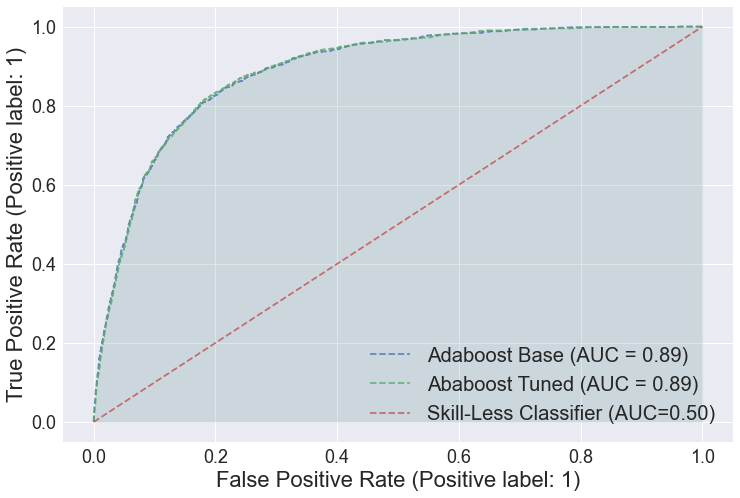

In [45]:
reload(utils)
plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 22,
                    'xtick.labelsize': 18,
                    'ytick.labelsize': 18})

utils.plot_roc_curve([adaboost_clf_base_drop, adaboost_clf_drop_best], X_test_drop, y_test,
                    labels=["Adaboost Base", "Ababoost Tuned"],
                    subplots_kwargs={"figsize": (12, 8)},
                    save_fpath=plots_dir/"adaboost_roc.png")

plt.show()

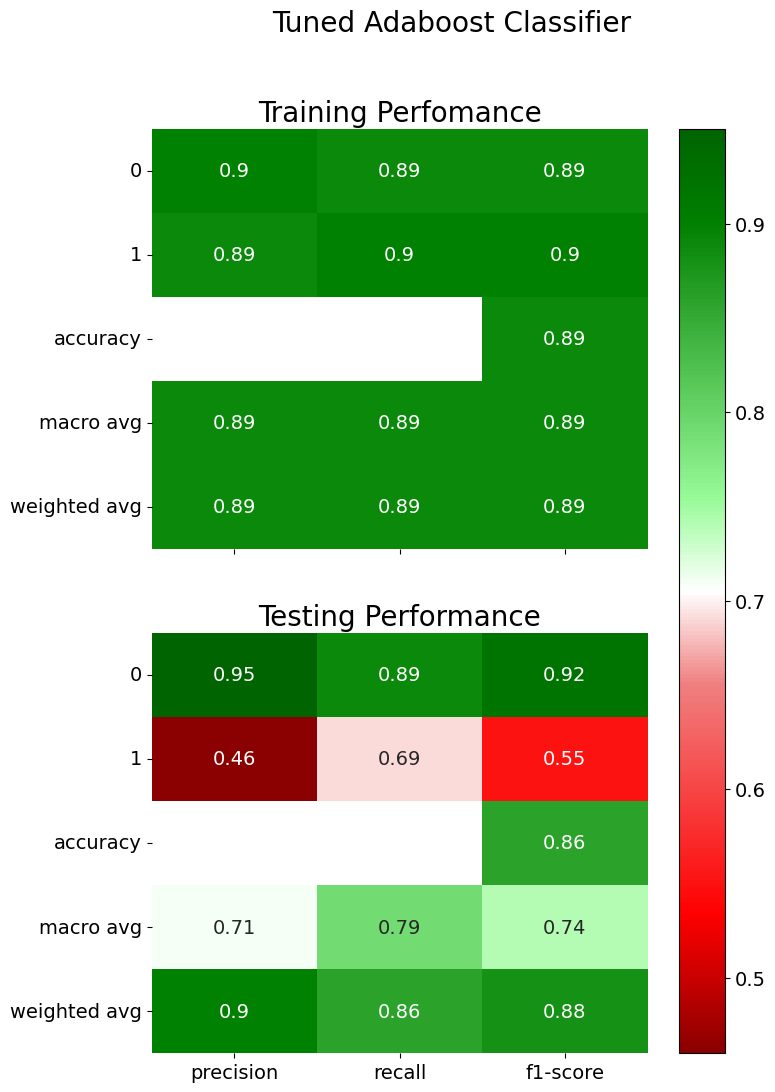

In [96]:
reload(utils)

plt.style.use("default")

plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 20,
                    'axes.titlesize': 20})

report_df = utils.compare_classification_reports([adaboost_clf_drop_best, adaboost_clf_drop_best],
                                                 [X_train_res_drop, X_test_drop],
                                                 [y_train_res_drop, y_test],
                                                 names=["Training Perfomance", "Testing Performance"],
                                                 suptitle="Tuned Adaboost Classifier",
                                                 plot=True,
                                                 subplot_kwargs=dict(nrows=2, figsize=(8, 12)),
                                                 cbar_orient="vertical",
                                                  save_fpath=plots_dir/"adaboost_best_report.png")

In [89]:
import pickle

In [33]:
type(adaboost_clf_base)

sklearn.ensemble._weight_boosting.AdaBoostClassifier

In [38]:
models_dir = Path("../models/adaboost")

assert models_dir.is_dir()

data_dir = models_dir/"data"

if not data_dir.is_dir():
    data_dir.mkdir()
    
pickle.dump(adaboost_clf_base_drop, open(models_dir/"adaboost_base.p", "wb"))
pickle.dump(adaboost_clf_drop_best, open(models_dir/"adaboost_best.p", "wb"))
pickle.dump((X_train_res_drop, X_test_drop, y_train_res, y_test), open(data_dir/"data.p", "wb"))

pickle.dump(low_features, open(models_dir/"low_importance_features.p", "wb"))

with open(models_dir/"README.md", "w") as f:
    f.write(f"""
    ## Adaboost models trained on SMOTE resampled data
    Contents:
    - `adaboost_base.p` - trained AdaBoostClassifier instance (baseline classifier)
    - `adaboost_best.p` - trained AdaBoostClassifier instance (best classifier)
    - `data.p` - data tuple (X_train_res_drop, X_test_drop, y_train_res, y_test)
    - `low_importance_features.p` - pd Series of low importance features
    The following low importance features have been dropped:
    {str(low_features.index.values)}
    """)